In [143]:


import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

covid_data=pd.read_csv("us-counties-recent.csv");

newdata=covid_data[covid_data["state"]=="Florida"];

agedata=pd.read_csv("cc-est2019-agesex-12.csv");
newdata2=agedata[agedata["YEAR"]==12];

educ_data=pd.read_csv("ACSST1Y2021.S1501-2022-10-17T192910.csv");

eddat=[];
columnsdat=[i for i in range(1,len(list(educ_data.columns)),12)];
columnsdat.insert(0,0)


eddat2=educ_data[educ_data.columns[columnsdat]]



# print(y) 
# newcovdata=newdata[newdata["deaths"]>=1000];
# sns.relplot(
#     data=newdata["deaths"], x=newdata["county"], y=newdata["deaths"]).set(xticklabels=[],title='Covid deaths per Florida county')


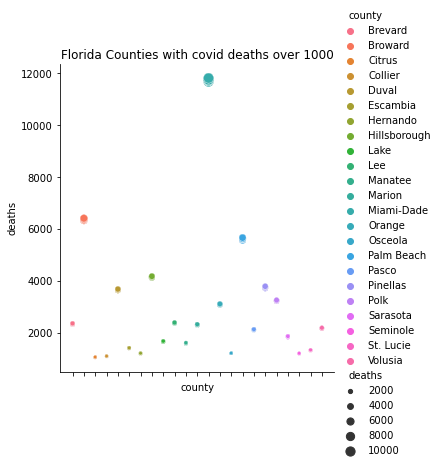

In [2]:
sns.relplot(data=newcovdata["deaths"], x=newcovdata["county"], y=newcovdata["deaths"], hue=newcovdata["county"], size=newcovdata["deaths"],sizes=(10, 100)).set(xticklabels=[], title="Florida Counties with covid deaths over 1000")


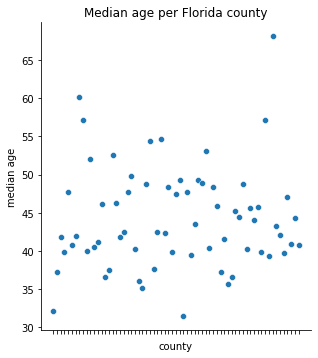

In [3]:
#median age used for the sake of plotting the data. gives an idea of the counties with older population  

sns.relplot(data=newdata2["MEDIAN_AGE_TOT"], x=newdata2["CTYNAME"], y=newdata2["MEDIAN_AGE_TOT"]).set(xticklabels=[],title='Median age per Florida county',xlabel="county",ylabel="median age")



[]
             date     county    state     fips   cases  deaths
324    2022-09-17    Alachua  Florida  12001.0   83099   739.0
326    2022-09-17        Bay  Florida  12005.0   52344   851.0
328    2022-09-17    Brevard  Florida  12009.0  164026  2321.0
329    2022-09-17    Broward  Florida  12011.0  726187  6333.0
331    2022-09-17  Charlotte  Florida  12015.0   44522   900.0
...           ...        ...      ...      ...     ...     ...
94834  2022-10-16  St. Johns  Florida  12109.0   74282   645.0
94835  2022-10-16  St. Lucie  Florida  12111.0   90837  1349.0
94836  2022-10-16     Sumter  Florida  12119.0   27825   647.0
94841  2022-10-16    Volusia  Florida  12127.0  142429  2198.0
94843  2022-10-16     Walton  Florida  12131.0   18875   224.0

[1230 rows x 6 columns]
94777      762.0
94779      862.0
94781     2368.0
94782     6416.0
94784      908.0
94785     1073.0
94786      928.0
94787     1108.0
94788      437.0
94791     3687.0
94792     1427.0
94793      405.0
94802     12

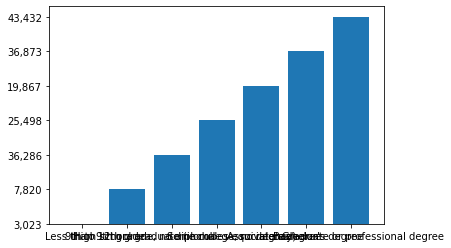

In [165]:
#Education data - looking at the 5 categories 
#normalized to the total population 

eddat2.columns = eddat2.columns.str.replace('County, Florida!!Total!!Estimate','')

totpop=[int(i.replace(",","")) for i in eddat2.iloc[6,1:]];
hs_data=[int(i.replace(",","")) for i in eddat2.iloc[10,1:]]
# less_9=

plt.bar(eddat2.iloc[7:14,0],eddat2.iloc[7:14,1])

norm_hs=[];


for i in range(1,len(totpop)):
    norm_hs.append((hs_data[i]/totpop[i]))
    
# holder=[];
# for i in :
#     holder.drop





print(list(newdata[newdata['county']=="Baker"].index))

newdata3=[];
for j in newdata["county"]:
    k=j+' '   
    b=list(newdata[newdata['county']==j].index)
    if k not in list(eddat2.columns):
        newdata=newdata.drop(b)
        
print(newdata)

v=np.max(newdata["deaths"])
print(newdata.iloc[(1230-41):1231,5])
g=newdata.iloc[(1230-41):1231,5]

z=np.min(g)   
print(z)

f=newdata[newdata['deaths']==v].index
d=newdata[newdata['deaths']==z].index
countymax=newdata.loc[f[-1]].at["county"]
countymin=newdata.loc[d[-1]].at["county"]

    
# print(eddat2[countymax+' '])
# print(eddat2[countymin+' '])

md_eddat=[int(eddat2[countymax+' '][i].replace(",",""))/int(eddat2[countymax+' '][6].replace(",","")) for i in range(7,14)]
# print(md_eddat)
mon_eddat=[int(eddat2[countymin+' '][i].replace(",",""))/int(eddat2[countymin+' '][6].replace(",","")) for i in range(7,14)]
print(mon_eddat)

Text(0.5, 1.0, 'Null distribution of U1 for a sample of 5 per group ')

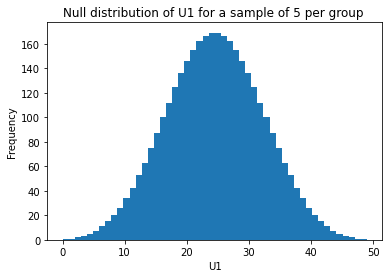

In [169]:

import itertools 

r=len(md_eddat); #number of samples in each group
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats for a length of 10 
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than 5 but for this there can only be 5 repeats
#per combination so this returns a list of the combinations that only have 5 repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=50); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for a sample of 5 per group ')

In [171]:
#finding whether the following vectors come from the same distribution using the u statistic 

#vectors with the sample values 

from scipy import stats 

u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(md_eddat)): #for loop iterating over the length of a 
    wins=[1 for x in range(0,len(md_eddat)) if mon_eddat[i]>md_eddat[x]]; #loops over all elements of b if the element in a is greater than
    #the element in b then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in a to the list u 

u1=sum(u) #sums up the total number of wins for a over b to get u1 
u2=(len(md_eddat)*len(mon_eddat))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 (a-b) is",u1,'and U2 is',u2) 
print("the likelihood of a and b being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(md_eddat,mon_eddat)[0],"U2=",stats.mannwhitneyu(mon_eddat,md_eddat)[0],"and p is",stats.mannwhitneyu(mon_eddat,md_eddat)[1])



U1 (a-b) is 23 and U2 is 26
the likelihood of a and b being from the same distribution is 0.9015151515151515
U and p values from the stats package. U1= 26.0 U2= 23.0 and p is 0.9015151515151516


[515]


InvalidIndexError: (slice(None, None, None), None)

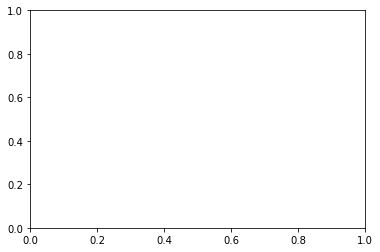

In [192]:
print(list(newdata2[newdata2['CTYNAME']=="Miami-Dade County"].index))

agedata2=[];



columnsdat2=[i for i in range(39,len(list(newdata2.columns)),3)];
columnsdat2.insert(0,9)
columnsdat2.insert(0,6)
columnsdat2.insert(0,4)


agedata2=newdata2[newdata2.columns[columnsdat2]]

# l=agedata2[newdata2['CTYNAME']==countymax+' County']
# plt.plot(l.iloc[0,2:],l.iloc[1:,2:])